# Dask Bag

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 

## Задачи для совместного разбора

In [1]:
import dask.bag as db
import json

In [2]:
with open("posts.json") as fp:
    posts = json.load(fp)

In [5]:
[len(p['title']) for p in posts][:5]

[74, 12, 59, 20, 18]

1. Посчитайте длину (в кол-ве символов) каждого заголовка.

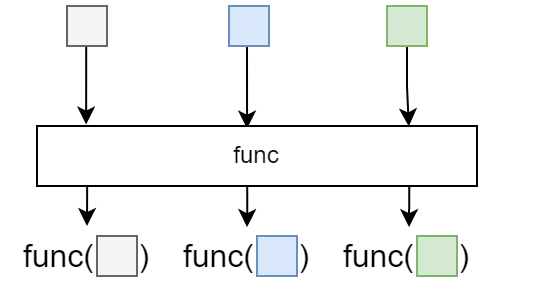

In [10]:
list(map(lambda p: len(p['title']), posts))[:5]

[74, 12, 59, 20, 18]

### $\mathbb{DASK}\text{ }\mathbb{BAGGG}$

In [13]:
%%time
bag = db.from_sequence(posts, npartitions=10)
bag.map(lambda p: len(p['title'])).compute()[:5]

Wall time: 765 ms


[74, 12, 59, 20, 18]

2. Выведите id постов, длина заголовков которых не более 15 символов.

In [17]:
[p['id'] for p in posts if len(p['title']) <=15]

[2, 40, 41, 57, 91]

In [23]:
list(filter(lambda p: len(p['title']) <=15, posts))[:1]

[{'userId': 1,
  'id': 2,
  'title': 'qui est esse',
  'body': 'est rerum tempore vitae\nsequi sint nihil reprehenderit dolor beatae ea dolores neque\nfugiat blanditiis voluptate porro vel nihil molestiae ut reiciendis\nqui aperiam non debitis possimus qui neque nisi nulla'}]

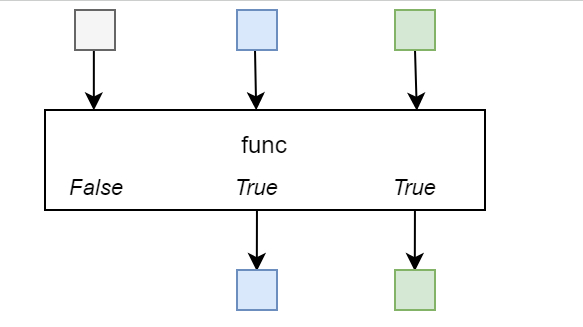

### $\mathbb{DASK}\text{ }\mathbb{BAGGG}$

In [24]:
bag.filter(
lambda p: len(p['title']) <=15).map(...)

dask.bag<Ellipsis, npartitions=10>

3. Посчитайте суммарную длину длин описаний постов

In [29]:
sum(len(p['body']) for p in posts)

16064

```
1 2 3 

(1 + 2) = 3
3 + 3 = 6

(1 + 2) + 3 = 6
```

In [31]:
from functools import reduce

In [32]:
reduce(lambda l, r: l + r,
      map(lambda p: len(p['body']),
          posts
         )
      )

16064

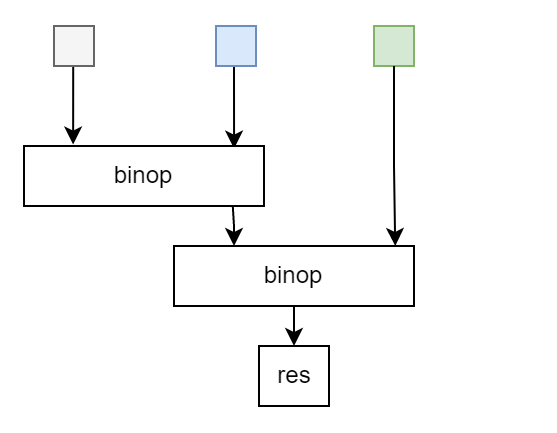

In [33]:
from functools import reduce

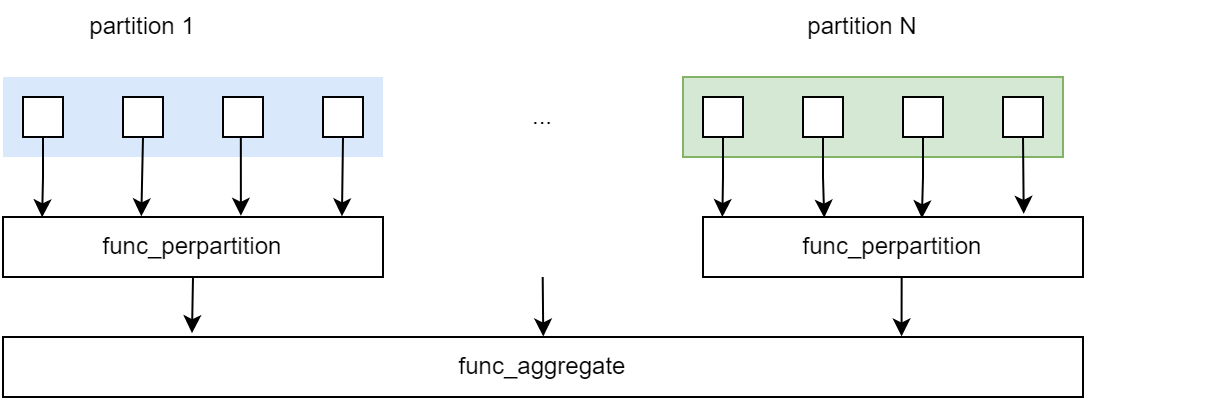

In [35]:
bag.map(lambda p: len(p['body'])).reduction(lambda partition: sum(partition),
                                                 lambda partition_results: sum(partition_results)).compute()

16064

4. При помощи метода `foldby` посчитайте, сколько постов написал каждый из пользователей.

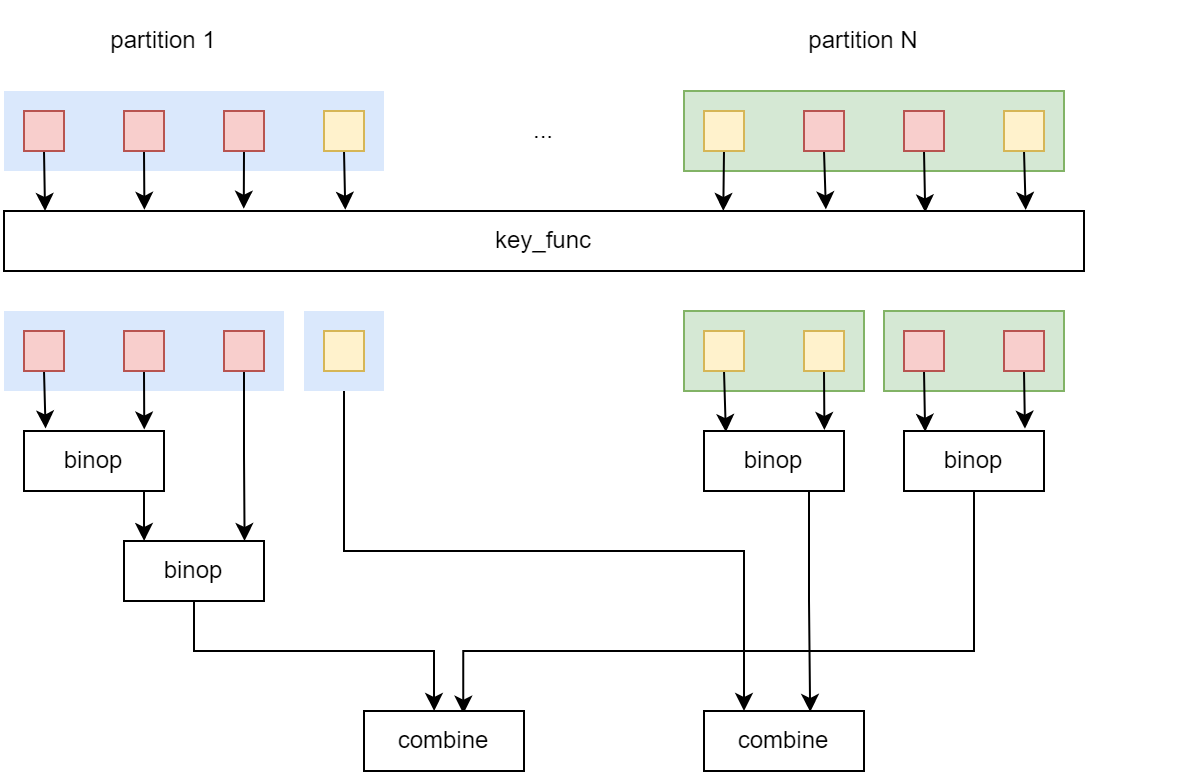

## Лабораторная работа 12

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

In [1]:
import dask.bag as db
import json
from functools import reduce
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

**1\.** В файлах архива `reviews_full.zip` находятся файлы, содержащие информацию об отзывах к рецептам в формате JSON Lines. Отзывы разделены на файлы в зависимости от оценки (например, в файле `reviews_1.json` находятся отзывы с оценкой 1). Считайте файлы из этого архива (предварительно разархивировав) в виде `dask.bag`. Преобразуйте текстовое содержимое файлов с помощью модуля `json`. Выведите на экран первые 5 элементов полученного `bag`.

In [2]:
reviews = db.read_text('C:/Users/micha/Downloads/reviews_full/*.json').map(json.loads)

In [3]:
reviews.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.'},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten'},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this often.'},
 {'u

9 057 540 - длина бэга, каждый файл по 1 509 590

**2\.** Модифицируйте функцию разбора JSON таким образом, чтобы в каждый словарь c информацией об отзыве добавить ключ `rating`. Значение получите на основе названия файла (см. аргумент `include_path` функции `read_text`), использовав для этого регулярное выражение. При создании `bag` разбейте набор данных на сегменты размером 128 Мб (см. аргумент `blocksize`).  Выведите на экран первые 5 элементов полученного `bag`.

In [4]:
def json_loads_wpath(args):
    patt = re.compile(r'.*(\d).*')
    line, path = args
    
    s = json.loads(line)
    s['rating'] = int(re.findall(patt, path)[0])

    return s

In [5]:
reviews_plus = db.read_text('C:/Users/micha/Downloads/reviews_full/*.json',
                            include_path=True,
                            blocksize="128MiB").map(json_loads_wpath)

In [6]:
%%time
reviews_plus.take(5)

Wall time: 1.2 s


({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.',
  'rating': 0},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten',
  'rating': 0},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will

**3\.** Посчитайте, сколько различных пользователей оставляли отзывы. Выведите это количество на экран.

In [7]:
reviews_plus.pluck(key='user_id').frequencies().count().compute()

226570

**4\.** Создайте версию `bag` из задания 2, в которой сохранены только отзывы, оставленные в 2014 и 2015 годах. Посчитайте и выведите на экран долю, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов.

In [8]:
reviews_2014_2015 = reviews_plus.filter(lambda line: ((str(line['date'])[:4])=='2014')|((str(line['date'])[:4])=='2015'))

In [9]:
reviews_2014_2015.count().compute()/reviews_plus.count().compute()

0.08117811237929945

**5\.** Для отзывов, оставленных в мае 2013 года, выполните предобработку: 
   * приведите строки к нижнему регистру;
   * обрежьте пробельные символы в начале и конце строки;
   * удалите все символы, кроме английских букв и пробелов.
   
Посчитайте и выведите на экран среднюю длину этих отзывов после предобработки. Если текстовое содержимое отзыва отсутствует, считайте, что длина отзыва равна нулю.

In [10]:
def text_editting(line):
    patt = re.compile(r'([^a-z]+)', re.I)
    return re.sub(patt, ' ', line['review']).lower().strip()

In [11]:
reviews_may_13 = reviews_plus.filter(lambda line: ((str(line['date'])[:4])=='2013')&((str(line['date'])[5:7])=='05'))

In [12]:
reviews_may_13.map(text_editting).map(len).mean().compute()

267.8459433898534

**6\.** Посчитайте, как часто встречается та или иная оценка:

   * в 2014 году;
   * в 2015 году.

Создайте `pd.DataFrame`, содержащий 2 столбца: `2014`, `2015` и 6 строк, имеющие индексы строк от 0 до 5. Дайте индексам строк имя `rating`. Выведите полученную таблицу на экран.

In [14]:
ratings_2014_2015 = dict()
for year in (2014,2015):
    filtered_reviews = reviews_plus.filter(lambda line: ((str(line['date'])[:4])==str(year)))
    ratings_2014_2015[str(year)] = dict(filtered_reviews.pluck(key='rating').frequencies().compute())

In [15]:
pd.DataFrame(ratings_2014_2015)

,2014,2015
0,21136,21336
1,4344,4902
2,4507,4873
3,12865,13667
4,58433,60980
5,258832,269399


**7\.**  Перераспределите данные из исходного `bag` на $k, k=2, 16, 32, 64, 128$ частей. Для каждого разбиения измерьте время выполнения расчета среднего рейтинга. Визуализируйте зависимость времени выполнения функции от числа сегментов. Временем, затрачиваемым на вызов метода `repartition`, можно пренебречь. Для итерации по $k$ допускается использовать циклы.

`OSError: [WinError 1450] Недостаточно системных ресурсов для завершения операции
`

In [16]:
time_list = list()
slice_list = [2, 16, 32, 64, 128]
for k in slice_list:
    rep_reviews = reviews_plus.repartition(k)
    
    start_time = time.time()
    rep_reviews.pluck(key='rating').mean().compute()
    time_list.append(time.time() - start_time)

In [17]:
time_list

[178.47835540771484,
 99.91124510765076,
 20.113303899765015,
 147.57797384262085,
 220.8821566104889]

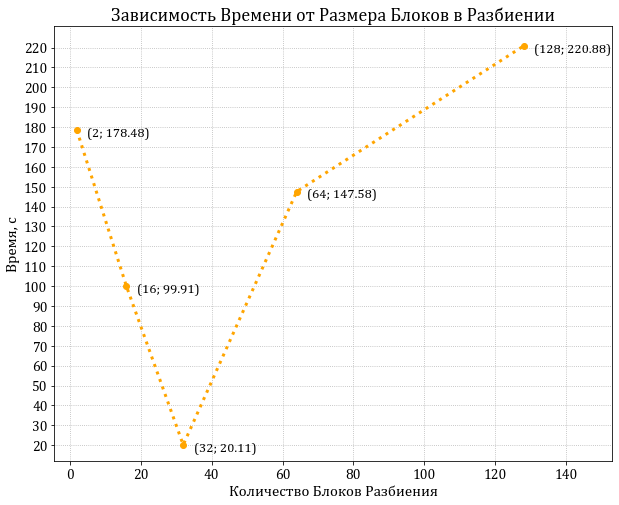

In [18]:
font = {'family': 'serif', 'serif': 'Cambria', 'weight': 'normal','size':14}
plt.rc('font',**font)

slice_list = [2, 16, 32, 64, 128]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(slice_list, time_list, 'orange', marker='o', lw=3, linestyle=':')
ax.grid(linestyle=':')

ax.set_ylim(min(time_list)-8)
ax.set_xlim(left=None, right=max(slice_list)+25)

ax.set_yticks(np.arange(round(min(time_list),0), max(time_list)+5, 10.0))

ax.set_title('Зависимость Времени от Размера Блоков в Разбиении', fontsize = 18)
ax.set_xlabel('Количество Блоков Разбиения', fontsize = 15)
ax.set_ylabel('Время, с', fontsize = 15)

for i in range(len(time_list)):
    ax.annotate(f'({int(slice_list[i])}; {np.round(time_list[i],2)})',
                xy = (slice_list[i]+3, time_list[i]-3), fontsize = 13)

plt.show()

**8\.** Будем считать, что сегмент _плохо перемешан_, если в нем _подряд_ идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `map_partitions`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `bag` из задачи 2. Также выведите на экран общее количество сегментов в `bag`, для которого производились расчеты.

In [25]:
reviews_plus.npartitions

28

In [34]:
# db.map_partitions(lambda line: line['date'], reviews_plus)

In [35]:
# reviews_plus.map_partitions(lambda line: line['date']).take(28)

In [36]:
# reviews_plus.map_partitions(lambda line: (str(line['date'])[:4])).take(5)

9\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `reduction`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `bag` из задачи 1. При реализации функций для свертки воспользуйтесь `functools.reduce`. 

**10\.** Используя метод `foldby`, подсчитайте и выведите на экран максимальную длину отзывов в зависимости от оценки `rating` в наборе, полученном в задании 2.

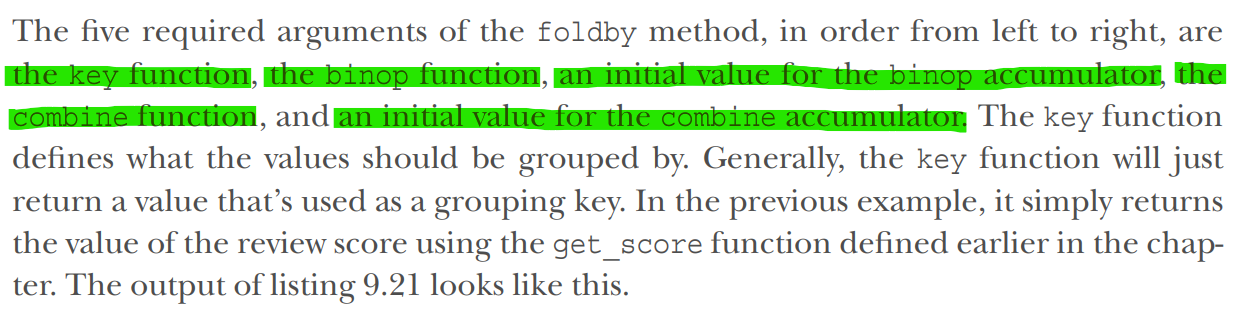

Метод `foldby` принимает два двоичных оператора, `binop` и `combine`. 
* `binop` берет текущий итог и новый элемент и выдает новый итог. 

* `combine` берет два итоговых значения и объединяет их. 

Каждый из этих двоичных операторов может иметь первое значение по умолчанию для total, прежде чем будет видно любое другое значение.

In [9]:
def max_length_foldby(ex, present):
    if present['review'] is not None:
        return max(ex, len(present['review']))
    else:
        return ex

In [15]:
review_len_foldby = reviews_plus.foldby(key='rating',
                                        binop=max_length_foldby,
                                        initial=0,
                                        combine=(lambda total1, total2: max(total1, total2)),
                                        combine_initial=0
                                       ).compute()

In [16]:
pd.DataFrame(review_len_foldby, columns=['Rating', 'MaxLength'])

,Rating,MaxLength
0,0,6972
1,1,5567
2,2,6972
3,3,4954
4,4,8587
5,5,8587
